In [1]:
#import libraries
import pandas as pd;
import geopandas as gpd;
import matplotlib.pyplot as plt;
%matplotlib notebook

import numpy as np; #Using numpy for regex
import pgeocode; #Used to convert postcodes to locations
from shapely.geometry import Point; # Shapely for converting latitude/longtitude to geometry
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon

import geopy.distance
from geopy.geocoders import Nominatim
import json;



import traveltimepy as ttpy
import os
from datetime import datetime #for examples
#TODO: store credentials in an environment variable
os.environ["TRAVELTIME_ID"] = '466b4c75'
os.environ["TRAVELTIME_KEY"] = 'aa473fed8d8638f1b576305a7e1fc019'

pd.set_option('display.precision', 1)



In [2]:
#Load Distribution Centre Data
df = pd.read_excel(r'DistributionCentres.xlsx', sheet_name='master')
df

,Line,Corp Name,Company Name,Initial Target,Building Name,Address,City,Region,PostCode,PostCode Sector,...,SFO Category,Bldg Size (k sq ft),SFO = Bldg,# Emp,Industry Type,Location,Submarket,Web Address,Unnamed: 31,Unnamed: 32
0,400,4PX Express,4PX Express UK,NaN,Dunstable 240,Arenson Way,Dunstable,East of England,LU5 4SB,LU5,...,200-500,200-249.9,Yes,0,"Professional, Scientific, and Technical Services",Main HQ Corp/LLC,West Bedfordshire Ind,http://en.4px.com/,NaN,NaN
1,572,4PX Express,4PX Express,NaN,Northampton 250,Weedon Rd,Northampton,East Midlands,NN7 3NF,NN7,...,200-500,200-249.9,Yes,0,Transportation and Warehousing,Single Location,Northamptonshire South In,NaN,NaN,NaN
2,359,4PX Express UK Co Ltd,4PX Express UK Co Ltd,NaN,Leicester 335,Leicester Ln,Leicester,East Midlands,LE19 1SA,LE1,...,200-500,250 to 499.9,Yes,0,Transportation and Warehousing,NaN,Blaby Ind,NaN,NaN,NaN
3,94,A Steadman and Son Ltd,A Steadman and Son Ltd,NaN,Steadmans,Wanell,Carlisle,North West,CA5 7HH,CA5,...,200-500,200-249.9,Yes,0,Manufacturing,Main HQ,Allerdale Ind,NaN,NaN,NaN
4,894,A.F.Blakemore and Son Ltd,A.F.Blakemore and Son Ltd,NaN,A F Blakemore & Son Ltd,Longacre,Willenhall,West Midlands,WV13 2JP,WV1,...,200-500,200-249.9,Yes,0,NaN,Divisional HQ,Walsall Ind,http://www.spar-international.com,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,461,Yusen Logistics,Yusen Logistics,3PL,NYK Building,Bradbourne Dr,Milton Keynes,South East,MK7 8BN,MK7,...,200-500,250 to 499.9,Yes,0,Transportation and Warehousing,NaN,Milton Keynes Ind,NaN,NaN,NaN
902,536,Yusen Logistics,Yusen Logistics,3PL,NaN,Cheaney Dr,Northampton,East Midlands,NN4 5FB,NN4,...,200-500,200-249.9,Yes,200,"Professional, Scientific, and Technical Services",Main HQ Corp/LLC,Northamptonshire South In,https://www.yusen-logistics.com,NaN,NaN
903,578,Yusen Logistics,Yusen Logistics,3PL,Yusen Logistics,Rutherford Dr,Wellingborough,East Midlands,NN8 6AQ,NN8,...,200-500,250 to 499.9,Yes,150,Transportation and Warehousing,Warehouse Corp/LLC,Wellingborough Ind,www.yusen-logistics.com,NaN,NaN
904,579,Yusen Logistics,Yusen Logistics,3PL,Yusen Logistics,Sywell Rd,Wellingborough,East Midlands,NN8 6BS,NN8,...,200-500,250 to 499.9,Yes,0,Transportation and Warehousing,Warehouse Corp/LLC,Wellingborough Ind,https://www.yusen-logistics.com/,NaN,NaN


In [3]:
existing = df[['PostCode', 'SF Occupied']]
existing['Category'] = 'Occupied'
existing = existing.rename(columns = {"SF Occupied": "sf"})
existing

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,PostCode,sf,Category
0,LU5 4SB,241092,Occupied
1,NN7 3NF,249579,Occupied
2,LE19 1SA,335158,Occupied
3,CA5 7HH,248333,Occupied
4,WV13 2JP,248004,Occupied
...,...,...,...
901,MK7 8BN,302585,Occupied
902,NN4 5FB,210000,Occupied
903,NN8 6AQ,341320,Occupied
904,NN8 6BS,370002,Occupied


In [4]:
#Exclude warehouses based on David Turner analysis
exclude_warehouses = ['WF2 0XE', 'DL5 6UG', 'S74 0PY', 'S9 1TQ', 'LS10 1AZ', 'WF6 2XX']
existing = existing[~existing.PostCode.str.match('|'.join(exclude_warehouses))]
existing

,PostCode,sf,Category
0,LU5 4SB,241092,Occupied
1,NN7 3NF,249579,Occupied
2,LE19 1SA,335158,Occupied
3,CA5 7HH,248333,Occupied
4,WV13 2JP,248004,Occupied
...,...,...,...
901,MK7 8BN,302585,Occupied
902,NN4 5FB,210000,Occupied
903,NN8 6AQ,341320,Occupied
904,NN8 6BS,370002,Occupied


In [5]:
land = pd.read_excel(r'savills_pipeline.xlsx', sheet_name='Land')
land = land[['Postcode', 'Remaining Sq Ft']]
land = land.rename(columns = {"Remaining Sq Ft": "sf", "Postcode": "PostCode"})
land["Category"] = "Land"
land

,PostCode,sf,Category
0,DN8 5GS,1.9e+06,Land
1,SR7 8SA,1.0e+06,Land
2,DL1 4PT,2.1e+06,Land
3,HU14 3BQ,2.1e+06,Land
4,DN14 0BS,2.6e+06,Land
5,SR5 3HY,1.7e+06,Land
6,LS26 9DP,2.0e+05,Land
7,DN40 1QR,9.0e+05,Land
8,DN3 3FQ,6.1e+05,Land
9,S81 8HH,1.2e+05,Land


In [6]:
pipeline = pd.read_excel(r'savills_pipeline.xlsx', sheet_name='Spec Pipeline')
pipeline = pipeline[['Postcode', 'Sq Ft']]
pipeline = pipeline.rename(columns = {"Sq Ft": "sf", "Postcode": "PostCode"})
pipeline['Category'] = 'Pipeline'
pipeline

,PostCode,sf,Category
0,DN11 0PS,848250,Pipeline
1,WF11 8DT,735000,Pipeline
2,S66 1UA,630000,Pipeline
3,LS25 2PG,487500,Pipeline
4,DN9 3RH,417570,Pipeline
5,DN11 0BG,400000,Pipeline
6,DN8 5GS,375000,Pipeline
7,S9 1TL,365814,Pipeline
8,S70 5SZ,340000,Pipeline
9,LS10 1SE,337021,Pipeline


In [7]:
df1 = pd.concat([existing, pipeline, land])
df1

,PostCode,sf,Category
0,LU5 4SB,2.4e+05,Occupied
1,NN7 3NF,2.5e+05,Occupied
2,LE19 1SA,3.4e+05,Occupied
3,CA5 7HH,2.5e+05,Occupied
4,WV13 2JP,2.5e+05,Occupied
...,...,...,...
47,DN8 5HT,3.5e+06,Land
48,DN9 3AN,3.4e+05,Land
49,S9 1QQ,1.7e+05,Land
50,DN31 2UT,1.2e+06,Land


In [8]:
slice = df1
slice['PostCode_District'] = slice['PostCode'].str.extract(r'([^\s]+)')
slice['PC_Area'] = slice['PostCode'].str.extract(r'(^[a-zA-Z][a-zA-Z]?)')
slice

,PostCode,sf,Category,PostCode_District,PC_Area
0,LU5 4SB,2.4e+05,Occupied,LU5,LU
1,NN7 3NF,2.5e+05,Occupied,NN7,NN
2,LE19 1SA,3.4e+05,Occupied,LE19,LE
3,CA5 7HH,2.5e+05,Occupied,CA5,CA
4,WV13 2JP,2.5e+05,Occupied,WV13,WV
...,...,...,...,...,...
47,DN8 5HT,3.5e+06,Land,DN8,DN
48,DN9 3AN,3.4e+05,Land,DN9,DN
49,S9 1QQ,1.7e+05,Land,S9,S
50,DN31 2UT,1.2e+06,Land,DN31,DN


In [9]:
areas_excluded = ['SA', 'SK', 'SN','SO','SP', 'ST','SY']
north_east=['LS','WF','HD', 'HG', 'S', 'HX', 'BD', 'DN', 'LN', 'NG', 'HU', 'YO', 'DL', 'TS', 'SR', 'DH', 'NE', 'DE']
df2 = slice[~(slice.PC_Area.str.match('|'.join(areas_excluded))) & (slice.PC_Area.str.match('|'.join(north_east)))]
df2 = df2[df2['sf']>0]
df2['msf'] = df2['sf'] / 1000000
df2 = df2.drop(columns=['sf'])
df2

,PostCode,Category,PostCode_District,PC_Area,msf
5,LS28 6DW,Occupied,LS28,LS,0.2
13,S35 1QP,Occupied,S35,S,0.3
14,DE6 3ET,Occupied,DE6,DE,0.2
22,DE72 2HP,Occupied,DE72,DE,0.6
23,DL3 0UW,Occupied,DL3,DL,0.4
...,...,...,...,...,...
47,DN8 5HT,Land,DN8,DN,3.5
48,DN9 3AN,Land,DN9,DN,0.3
49,S9 1QQ,Land,S9,S,0.2
50,DN31 2UT,Land,DN31,DN,1.2


In [10]:
#Weight distribution centres by stage of development
existing_weight = 1
pipeline_weight = 0.8
land_weight = 0.2

df3 = df2
df3['wmsf'] = np.where(df3['Category'] == 'Occupied', df3['msf'] * existing_weight, np.where(df3['Category'] == 'Pipeline', df3['msf'] * pipeline_weight, df3['msf'] * land_weight))
df3

,PostCode,Category,PostCode_District,PC_Area,msf,wmsf
5,LS28 6DW,Occupied,LS28,LS,0.2,2.1e-01
13,S35 1QP,Occupied,S35,S,0.3,3.5e-01
14,DE6 3ET,Occupied,DE6,DE,0.2,2.1e-01
22,DE72 2HP,Occupied,DE72,DE,0.6,6.0e-01
23,DL3 0UW,Occupied,DL3,DL,0.4,3.8e-01
...,...,...,...,...,...,...
47,DN8 5HT,Land,DN8,DN,3.5,7.0e-01
48,DN9 3AN,Land,DN9,DN,0.3,6.9e-02
49,S9 1QQ,Land,S9,S,0.2,3.4e-02
50,DN31 2UT,Land,DN31,DN,1.2,2.4e-01


In [11]:
#Set up terminal options
data = [['FL Leeds', 53.7673, -1.5062, (5,5)], ['FL Doncaster', 53.508157, -1.125958, (5,5)], ['iPort', 53.48247871041433,-1.1087608337402344, (5,-5)], ['Tinsley', 53.4011002,-1.3850275, (5,5)], ['Gascoigne Wood', 53.7780692,-1.2133953,  (5,5)], ['Wakefield', 53.71375,-1.4077798, (5,5)],  ['Teesport', 54.602699,-1.1465941,  (5,5)], ['East Midlands Gateway', 52.8380088,-1.3067932, (5,5)], ['Goole', 53.700448, -0.882403, (5,5)], ['Hatfield', 53.592417, -1.020067, (5,5)]]
fl = [['FL Leeds', 53.7673, -1.5062, (5,5)], ['FL Doncaster', 53.508157, -1.125958, (5,5)]]  
# Create the pandas DataFrame
all_locations = pd.DataFrame(data, columns=['Terminal', 'Lat', 'Long', 'map_offset'])  

# creating a geometry column 
geometry_all = [Point(xy) for xy in zip(all_locations['Long'], all_locations['Lat'])]

# Coordinate reference system : WGS84
#crs = {'init': 'epsg:4326'}
crs = 'epsg:4326'
# Creating a Geographic data frame 
all_points = gpd.GeoDataFrame(all_locations, crs=crs, geometry=geometry_all)

all_points

,Terminal,Lat,Long,map_offset,geometry
0,FL Leeds,53.8,-1.5,"(5, 5)",POINT (-1.50620 53.76730)
1,FL Doncaster,53.5,-1.1,"(5, 5)",POINT (-1.12596 53.50816)
2,iPort,53.5,-1.1,"(5, -5)",POINT (-1.10876 53.48248)
3,Tinsley,53.4,-1.4,"(5, 5)",POINT (-1.38503 53.40110)
4,Gascoigne Wood,53.8,-1.2,"(5, 5)",POINT (-1.21340 53.77807)
5,Wakefield,53.7,-1.4,"(5, 5)",POINT (-1.40778 53.71375)
6,Teesport,54.6,-1.1,"(5, 5)",POINT (-1.14659 54.60270)
7,East Midlands Gateway,52.8,-1.3,"(5, 5)",POINT (-1.30679 52.83801)
8,Goole,53.7,-0.9,"(5, 5)",POINT (-0.88240 53.70045)
9,Hatfield,53.6,-1.0,"(5, 5)",POINT (-1.02007 53.59242)


## Heatmapping Postcode District Level (e.g., LN10)

<IPython.core.display.Javascript object>


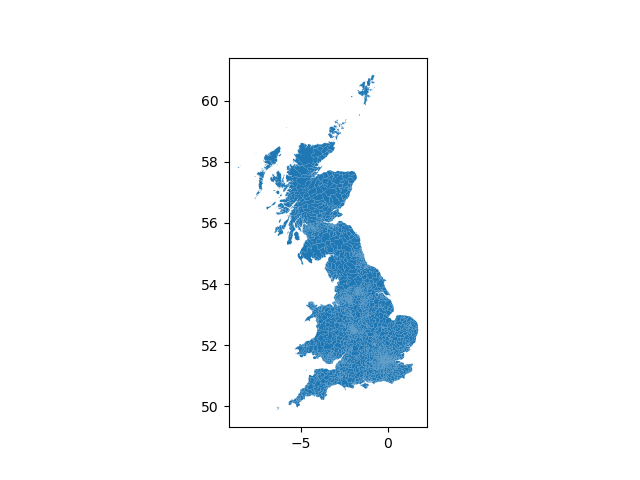

In [12]:
#Load and check map of PostCode Districts
fp = "postcodes/Districts.shp"
map_df = gpd.read_file(fp)
map_df.plot()

In [13]:
#Examine Header data of map
map_df.head()

,name,geometry
0,AB10,"POLYGON ((-2.11645 57.14656, -2.11655 57.14663..."
1,AB11,"MULTIPOLYGON (((-2.05257 57.13426, -2.05729 57..."
2,AB12,"MULTIPOLYGON (((-2.12807 57.03684, -2.12986 57..."
3,AB13,"POLYGON ((-2.26153 57.10694, -2.27015 57.11525..."
4,AB14,"POLYGON ((-2.26153 57.10694, -2.26315 57.10619..."


In [14]:
mappable_data = df2.groupby('PostCode_District').agg({'wmsf': 'sum'})
mappable_data.sort_values(by='wmsf', ascending=False)

,wmsf
PostCode_District,
DE74,6.2e+00
DN11,5.7e+00
DE14,3.6e+00
DN3,3.4e+00
DN14,3.4e+00
...,...
DN1,4.4e-02
LS26,4.0e-02
DN2,2.6e-02


In [15]:
reset_index = map_df.set_index("name")
merged = reset_index.join(mappable_data)
merged["wmsf"] = merged["wmsf"].fillna(0)
merged

,geometry,wmsf
name,,
AB10,"POLYGON ((-2.11645 57.14656, -2.11655 57.14663...",0.0
AB11,"MULTIPOLYGON (((-2.05257 57.13426, -2.05729 57...",0.0
AB12,"MULTIPOLYGON (((-2.12807 57.03684, -2.12986 57...",0.0
AB13,"POLYGON ((-2.26153 57.10694, -2.27015 57.11525...",0.0
AB14,"POLYGON ((-2.26153 57.10694, -2.26315 57.10619...",0.0
...,...,...
YO90,"MULTIPOLYGON (((-1.08958 53.95931, -1.08891 53...",0.0
YO91,"POLYGON ((-1.06530 53.97796, -1.06634 53.97830...",0.0
ZE1,"MULTIPOLYGON (((-1.17282 60.12108, -1.18797 60...",0.0


<IPython.core.display.Javascript object>


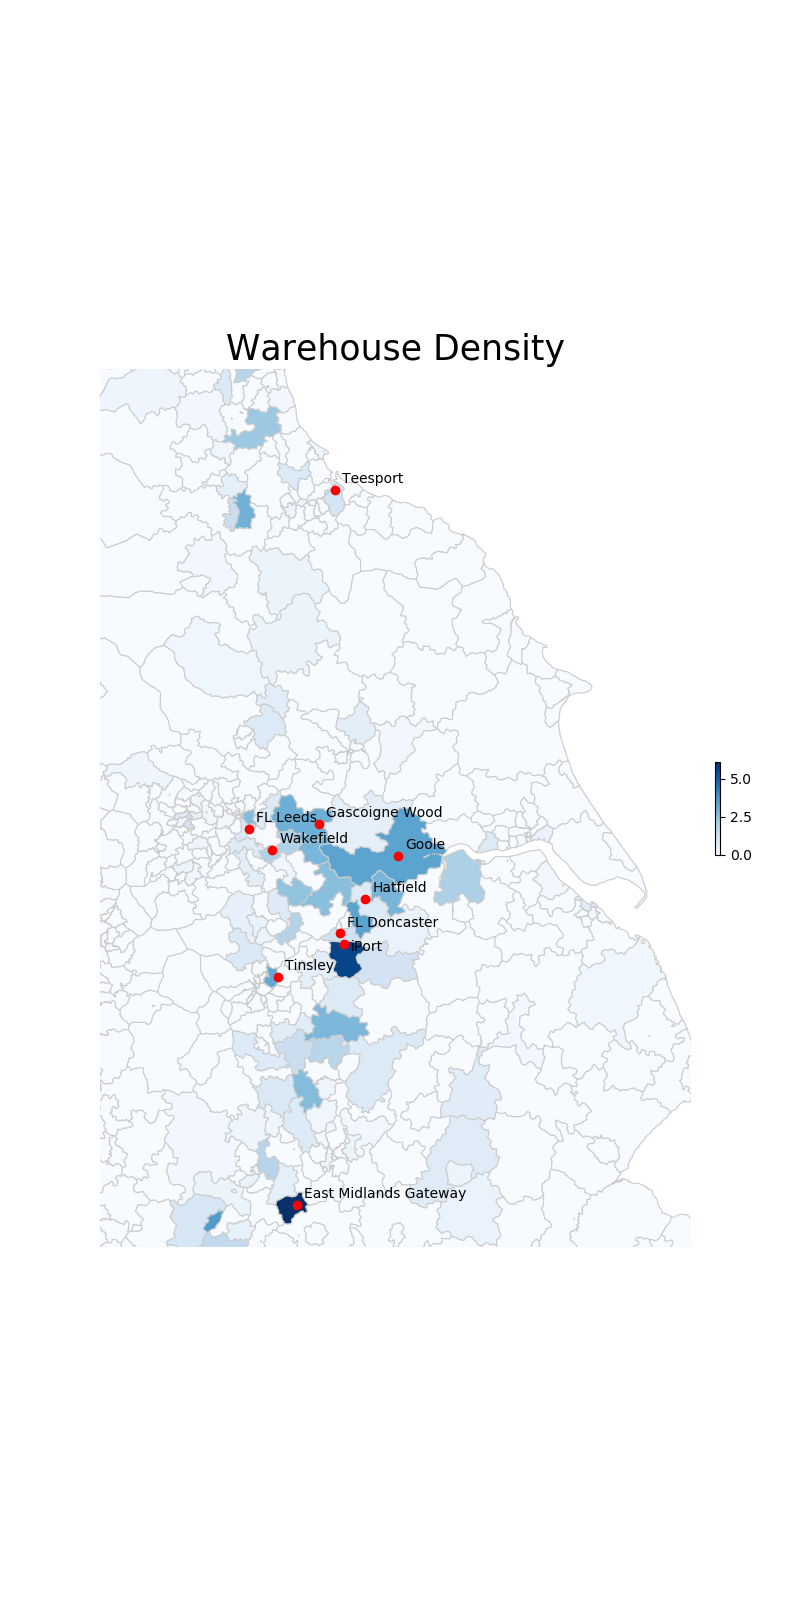

In [16]:
variable = "wmsf"
vmin, vmax = 0, merged["wmsf"].max()
fig, ax = plt.subplots(1, figsize=(8, 16))

# add a title and remove axis
ax.set_title("Warehouse Density", fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.axis('off')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, fraction=0.0075, pad=0.04)

for x in all_points['Terminal']:
    ax.annotate(x, (all_points[all_points['Terminal'].str.contains(x)]["Long"].iloc[0], all_points[all_points['Terminal'].str.contains(x)]["Lat"].iloc[0]), xycoords='data', xytext=all_points[all_points['Terminal'].str.contains(x)]["map_offset"].iloc[0], textcoords="offset points")


merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
all_points.plot(ax=ax, color="red")


# Distance Analysis

Steps:
* Get Lat/Long for each postcode from PostCode csv lookup
* Get distance for each Terminal to each DC
* Convert to miles and haulier bands


In [17]:
df3

,PostCode,Category,PostCode_District,PC_Area,msf,wmsf
5,LS28 6DW,Occupied,LS28,LS,0.2,2.1e-01
13,S35 1QP,Occupied,S35,S,0.3,3.5e-01
14,DE6 3ET,Occupied,DE6,DE,0.2,2.1e-01
22,DE72 2HP,Occupied,DE72,DE,0.6,6.0e-01
23,DL3 0UW,Occupied,DL3,DL,0.4,3.8e-01
...,...,...,...,...,...,...
47,DN8 5HT,Land,DN8,DN,3.5,7.0e-01
48,DN9 3AN,Land,DN9,DN,0.3,6.9e-02
49,S9 1QQ,Land,S9,S,0.2,3.4e-02
50,DN31 2UT,Land,DN31,DN,1.2,2.4e-01


In [18]:
postcode_latlong = pd.read_csv(r'ukpostcodes.csv')
postcode_latlong

,id,postcode,latitude,longitude
0,1,AB10 1XG,57.1,-2.1
1,2,AB10 6RN,57.1,-2.1
2,3,AB10 7JB,57.1,-2.1
3,4,AB11 5QN,57.1,-2.1
4,5,AB11 6UL,57.1,-2.1
...,...,...,...,...
1787186,2697132,YO7 3FX,54.2,-1.4
1787187,2697133,YO7 9DF,54.2,-1.3
1787188,2697134,YO8 1FB,53.8,-1.1
1787189,2697135,YO8 6RR,53.8,-0.9


In [19]:
df4 = pd.merge(left=df3, right=postcode_latlong, how="inner", left_on="PostCode", right_on="postcode")
df4 = df4.drop(columns=['id', 'postcode'])
df4

,PostCode,Category,PostCode_District,PC_Area,msf,wmsf,latitude,longitude
0,LS28 6DW,Occupied,LS28,LS,0.2,2.1e-01,53.8,-1.7
1,S35 1QP,Occupied,S35,S,0.3,3.5e-01,53.5,-1.5
2,DE6 3ET,Occupied,DE6,DE,0.2,2.1e-01,53.0,-1.6
3,DE72 2HP,Occupied,DE72,DE,0.6,6.0e-01,52.9,-1.3
4,DL3 0UW,Occupied,DL3,DL,0.4,3.8e-01,54.5,-1.6
...,...,...,...,...,...,...,...,...
269,DN8 5HT,Land,DN8,DN,3.5,7.0e-01,53.6,-1.0
270,DN9 3AN,Land,DN9,DN,0.3,6.9e-02,53.5,-1.0
271,S9 1QQ,Land,S9,S,0.2,3.4e-02,53.4,-1.4
272,DN31 2UT,Land,DN31,DN,1.2,2.4e-01,53.6,-0.1


In [20]:
unique_pc = df4.groupby(['PostCode', 'latitude', 'longitude'])['PostCode_District'].count().reset_index()
unique_pc = unique_pc.drop(columns=['PostCode_District'])
unique_pc

,PostCode,latitude,longitude
0,BD10 8RU,53.8,-1.7
1,BD12 7EZ,53.7,-1.7
2,BD19 6BU,53.7,-1.7
3,BD20 6RA,53.9,-2.0
4,BD3 9SX,53.8,-1.7
...,...,...,...
216,YO41 1HS,54.0,-0.9
217,YO51 9NN,54.1,-1.4
218,YO7 3HE,54.2,-1.4
219,YO7 3HP,54.2,-1.4


In [21]:
locations = []
arrival_location_ids = unique_pc['PostCode']
for location in all_points['Terminal']:
    data={"id": location, "coords": {"lat": all_points[all_points['Terminal'].str.contains(location)]["Lat"].iloc[0], 'lng': all_points[all_points['Terminal'].str.contains(location)]["Long"].iloc[0]}}
    locations.append(data)
    
for location in arrival_location_ids:
    data={"id": location, "coords": {"lat": unique_pc[unique_pc['PostCode'].str.match(location)]["latitude"].iloc[0], 'lng': unique_pc[unique_pc['PostCode'].str.match(location)]["longitude"].iloc[0]}}
    locations.append(data)

locations

[{'id': 'FL Leeds', 'coords': {'lat': 53.7673, 'lng': -1.5062}},
 {'id': 'FL Doncaster', 'coords': {'lat': 53.508157, 'lng': -1.125958}},
 {'id': 'iPort',
  'coords': {'lat': 53.48247871041433, 'lng': -1.1087608337402344}},
 {'id': 'Tinsley', 'coords': {'lat': 53.4011002, 'lng': -1.3850275}},
 {'id': 'Gascoigne Wood', 'coords': {'lat': 53.7780692, 'lng': -1.2133953}},
 {'id': 'Wakefield', 'coords': {'lat': 53.71375, 'lng': -1.4077798}},
 {'id': 'Teesport', 'coords': {'lat': 54.602699, 'lng': -1.1465941}},
 {'id': 'East Midlands Gateway',
  'coords': {'lat': 52.8380088, 'lng': -1.3067932}},
 {'id': 'Goole', 'coords': {'lat': 53.700448, 'lng': -0.882403}},
 {'id': 'Hatfield', 'coords': {'lat': 53.592417, 'lng': -1.020067}},
 {'id': 'BD10 8RU', 'coords': {'lat': 53.836105, 'lng': -1.734147}},
 {'id': 'BD12 7EZ', 'coords': {'lat': 53.749476, 'lng': -1.733666}},
 {'id': 'BD19 6BU', 'coords': {'lat': 53.741505000000004, 'lng': -1.732909}},
 {'id': 'BD20 6RA', 'coords': {'lat': 53.90016, 'lng

In [22]:
combined_searches = []
#There was a problem with API limits that set max elements
#So we need go through in batches of 100 and process after
step = 100
rows = len(unique_pc)
steps = int(rows / step)


for terminal in all_points['Terminal']:
    for x in range(steps+1):
        search = {
          "id": terminal,
          "departure_location_id": terminal,
          "arrival_location_ids": arrival_location_ids.tolist()[x*step:min(rows, (x+1) * step)],
          "transportation": {"type": "driving"},
          "departure_time":  "2022-10-12T09:00:00Z",
          "travel_time": 4*60*60,
          "properties": ["travel_time", "distance"],
          "range": {"enabled": True, "max_results": 1, "width": 600}
        }
        output = ttpy.time_filter(locations=locations, departure_searches=search)
        combined_searches.append(output)

combined_searches

[{'results': [{'search_id': 'FL Leeds',
    'locations': [{'id': 'HU3 4SA',
      'properties': [{'travel_time': 3967, 'distance': 88408}]},
     {'id': 'DL3 0UR',
      'properties': [{'travel_time': 4361, 'distance': 109234}]},
     {'id': 'DE5 8NN',
      'properties': [{'travel_time': 4610, 'distance': 102633}]},
     {'id': 'DE14 2SY',
      'properties': [{'travel_time': 6407, 'distance': 150499}]},
     {'id': 'DN14 7UW',
      'properties': [{'travel_time': 2497, 'distance': 55733}]},
     {'id': 'DN4 5JQ',
      'properties': [{'travel_time': 2521, 'distance': 54111}]},
     {'id': 'DE65 5BY',
      'properties': [{'travel_time': 6156, 'distance': 150607}]},
     {'id': 'DE55 2FH',
      'properties': [{'travel_time': 3703, 'distance': 90391}]},
     {'id': 'DN17 3DA',
      'properties': [{'travel_time': 3124, 'distance': 74240}]},
     {'id': 'DL1 1RW',
      'properties': [{'travel_time': 4714, 'distance': 110937}]},
     {'id': 'DE14 3EG',
      'properties': [{'travel_tim

In [23]:
travel_analysis = unique_pc.set_index('PostCode')

for terminal in all_points['Terminal']:
    travel_analysis[terminal + '_distance'] = None
    travel_analysis[terminal + '_time'] = None


    
for x in combined_searches:
    origin = x['results'][0]['search_id']
    for y in x['results'][0]['locations']:
        travel_analysis.at[y['id'], origin+'_distance'] = y['properties'][0]['distance'] / 1.60934 / 1000
        travel_analysis.at[y['id'], origin+'_time'] = y['properties'][0]['travel_time'] / 60
        #travel_data[y['id']] = y['properties'][0]['distance'] / 1.60934 / 1000

travel_analysis
        

,latitude,longitude,FL Leeds_distance,FL Leeds_time,FL Doncaster_distance,FL Doncaster_time,iPort_distance,iPort_time,Tinsley_distance,Tinsley_time,...,Wakefield_distance,Wakefield_time,Teesport_distance,Teesport_time,East Midlands Gateway_distance,East Midlands Gateway_time,Goole_distance,Goole_time,Hatfield_distance,Hatfield_time
PostCode,,,,,,,,,,,,,,,,,,,,,
BD10 8RU,53.8,-1.7,1e+01,4e+01,5e+01,7e+01,5e+01,7e+01,5e+01,7e+01,...,2e+01,4e+01,7e+01,1e+02,9e+01,1e+02,4e+01,6e+01,5e+01,6e+01
BD12 7EZ,53.7,-1.7,1e+01,2e+01,4e+01,5e+01,4e+01,5e+01,4e+01,5e+01,...,2e+01,2e+01,9e+01,1e+02,8e+01,9e+01,4e+01,5e+01,4e+01,5e+01
BD19 6BU,53.7,-1.7,1e+01,2e+01,4e+01,5e+01,4e+01,5e+01,4e+01,5e+01,...,2e+01,2e+01,9e+01,1e+02,8e+01,9e+01,4e+01,4e+01,4e+01,4e+01
BD20 6RA,53.9,-2.0,3e+01,6e+01,6e+01,9e+01,6e+01,9e+01,6e+01,9e+01,...,3e+01,7e+01,8e+01,1e+02,1e+02,1e+02,6e+01,9e+01,6e+01,9e+01
BD3 9SX,53.8,-1.7,1e+01,3e+01,4e+01,6e+01,4e+01,6e+01,4e+01,6e+01,...,2e+01,3e+01,7e+01,1e+02,9e+01,1e+02,4e+01,5e+01,4e+01,5e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YO41 1HS,54.0,-0.9,4e+01,6e+01,5e+01,7e+01,5e+01,7e+01,7e+01,9e+01,...,4e+01,6e+01,7e+01,1e+02,1e+02,1e+02,3e+01,6e+01,4e+01,6e+01
YO51 9NN,54.1,-1.4,3e+01,4e+01,5e+01,6e+01,5e+01,6e+01,6e+01,7e+01,...,3e+01,4e+01,5e+01,8e+01,1e+02,1e+02,5e+01,5e+01,5e+01,5e+01
YO7 3HE,54.2,-1.4,4e+01,5e+01,6e+01,7e+01,6e+01,7e+01,7e+01,8e+01,...,4e+01,5e+01,4e+01,6e+01,1e+02,1e+02,6e+01,6e+01,6e+01,6e+01


In [25]:
df5 = pd.merge(left=df4, right=travel_analysis, left_on="PostCode", right_on="PostCode")

In [26]:
df5.to_csv('DC_data_processed.csv')